## import dependency

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [85]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Input, Dense,MaxPooling2D, Flatten,Conv2D
import tensorflow as tf

In [86]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)    
    

In [87]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

## collecting negative data

In [88]:
import os

# Define the path to the directory where you want to move the files
NEG_PATH = 'data/negative'

# Ensure the NEG_PATH directory exists
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)

# Iterate over the directories and files in the 'lfw' directory
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    if os.path.isdir(dir_path):  # Check if it is indeed a directory
        for file in os.listdir(dir_path):
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)

            # Print paths to debug
            print(f'Moving {EX_PATH} to {NEW_PATH}')

            os.replace(EX_PATH, NEW_PATH)


## collecting positive and anchore data

In [89]:
import uuid

In [90]:
import cv2

# Initialize the video capture object with the correct device index
cap = cv2.VideoCapture(0)  # Try different indices if necessary (0, 1, 2, etc.)

if not cap.isOpened():
    print("Error: Could not open video device.")
else:
    print("Video device opened successfully.")
    while cap.isOpened():
        ret, frame = cap.read()
        frame=frame[120:120+250,200:200+250,:]
        ## collecting anchore
        if cv2.waitKey(1) & 0xFF == ord('a'):
            imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        ## collecting positive
        if cv2.waitKey(1) & 0xFF == ord('p'):
            imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        if not ret:
            print("Error: Failed to capture image.")
            break
        # Check if the frame is empty
        if frame is None or frame.size == 0:
            continue
        cv2.imshow('Image Collection', frame)
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


Video device opened successfully.


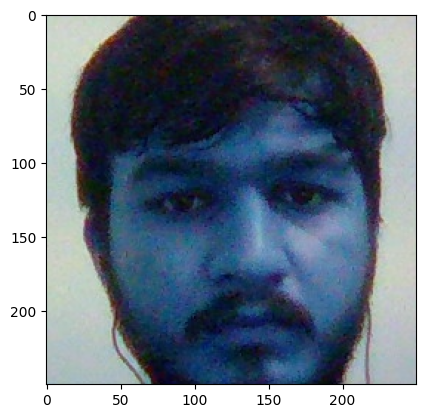

In [91]:
plt.imshow(frame[:,:,:])

In [92]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [93]:
dir_test = anchor.as_numpy_iterator()

In [94]:
print(dir_test.next())

b'data\\anchor\\acda7ed1-37bb-11ef-87ea-fc349794977f.jpg'


In [95]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [96]:
img = preprocess('data\\anchor\\ac0a02c6-37bb-11ef-8c9a-fc349794977f.jpg')

In [97]:
img.numpy().max()

0.88284314

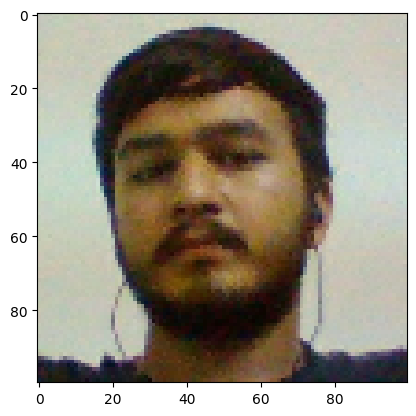

In [98]:
plt.imshow(img)

In [99]:
# (anchore , positive ) => 1,1,1,1,1
# (anchore , negative )=> 0,0,0,0,0

In [100]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [101]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [102]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [103]:
exampple

(b'data\\anchor\\b67c8c19-37bb-11ef-9af0-fc349794977f.jpg',
 b'data\\positive\\c44874ad-37bb-11ef-a662-fc349794977f.jpg',
 1.0)

In [113]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [114]:
res = preprocess_twin(*exampple)


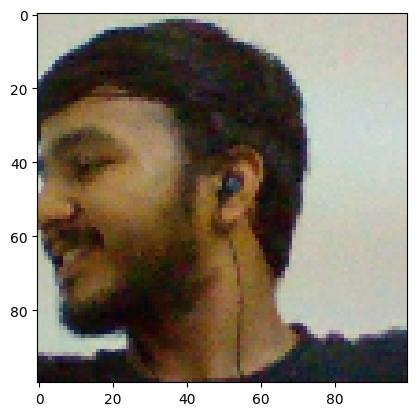

In [115]:
plt.imshow(res[1])

In [116]:
res[2]

1.0

## Build dataloader pipline

In [125]:
# Build dataloader pipeline
data = data.map(preprocess_twin)

TypeError: in user code:

    File "C:\Users\smit1\AppData\Local\Temp\ipykernel_13296\3683664855.py", line 2, in preprocess_twin  *
        return(preprocess(input_img), preprocess(validation_img), label)
    File "C:\Users\smit1\AppData\Local\Temp\ipykernel_13296\3691649184.py", line 4, in preprocess  *
        byte_img = tf.io.read_file(file_path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


In [122]:
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [121]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [128]:
samples=data.as_numpy_iterator()

In [131]:
len(samples.next())

3

In [144]:
samp=samples.next()

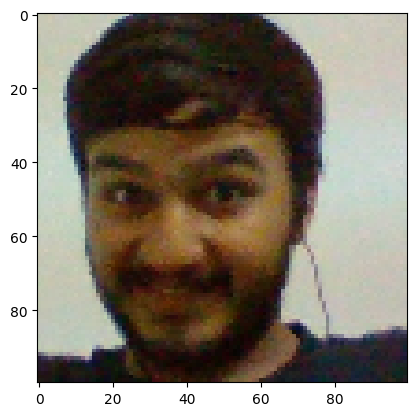

In [145]:
plt.imshow(samp[1])

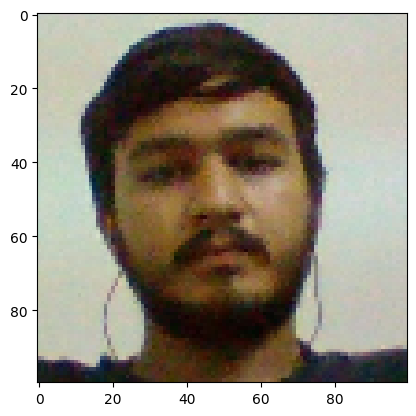

In [146]:
plt.imshow(samp[0])

In [147]:
samp[2]

1.0

In [119]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [120]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [126]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [127]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>